# Markov Chain Monte Carlo

In [1]:
%matplotlib inline
import pylab as plt
import numpy as np
import scipy.stats
import scipy.optimize

In [2]:
# Example data set from  arxiv:1008.4686, table 1
data = np.array([[201,592,61],[244,401,25],[47 ,583,38],[287,402,15],[203,495,21],[58 ,173,15],[210,479,27],
                 [202,504,14],[198,510,30],[158,416,16],[165,393,14],[201,442,25],[157,317,52],[131,311,16],
                 [166,400,34],[160,337,31],[186,423,42],[125,334,26],[218,533,16],[146,344,22],]).astype(float)
x = data[:,0]
y = data[:,1]
yerr = data[:,2]

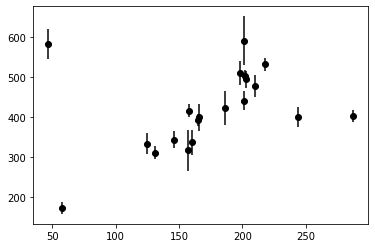

In [3]:
plt.errorbar(x, y, yerr=yerr, fmt='o', color='k');

This is an example dataset with "outliers" -- data points that just don't seem to fit the trend.

Outliers might arise due to "glitches" in your observational hardware (or external interference like cosmic rays in astronomical imaging surveys), or might be due to problems with the sample of objects you're plotting -- maybe not all these stars are actually part of the same cluster.

We can fit a linear model to this.  In fact, the model will still be confident about what the best-fit parameters are, even if the fit is subjectively terrible.

In [4]:
def log_likelihood_one(params, x, y, yerr):
    b,m = params
    ypred = b + m * x
    chi = (y - ypred) / yerr
    loglike = -0.5 * np.sum(chi**2) - np.sum(np.log(yerr) + 0.5 * np.log(2. * np.pi))
    return loglike

A wrapper function because we're calling *minimize* but we want to maximize log-likelihood.

In [5]:
def neg_ll_one(*X):
    return -log_likelihood_one(*X)

In [6]:
R = scipy.optimize.minimize(neg_ll_one, [0.,0.], args=(x, y, yerr))
R

      fun: 227.29878169962575
 hess_inv: array([[ 2.07191216e+02, -1.05422598e+00],
       [-1.05422598e+00,  5.99127370e-03]])
      jac: array([-3.81469727e-06, -3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 33
      nit: 8
     njev: 11
   status: 0
  success: True
        x: array([213.27354327,   1.07674726])

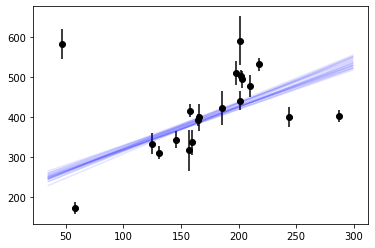

In [7]:
plt.errorbar(x, y, yerr=yerr, fmt='o', color='k');
ax = plt.axis()
# Draw a sampling of B,M parameter values that are consistent with the fit,
# using the estimated inverse-Hessian matrix (parameter covariance)
BM = scipy.stats.multivariate_normal.rvs(mean=R.x, cov=R.hess_inv, size=20)
xx = np.array(ax[:2])
for b,m in BM:
    plt.plot(xx, b + xx*m, 'b-', alpha=0.1)

Does this fit make you happy?

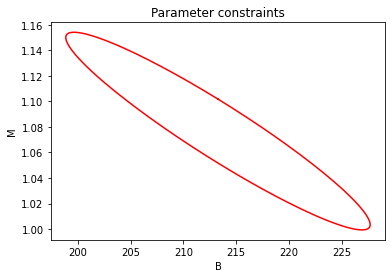

In [8]:
# You can also plot the ellipse showing the constraints in B,M space by manipulating hess_inv:
U,s,V = np.linalg.svd(R.hess_inv)
S = np.dot(U, np.diag(np.sqrt(s)))
th = np.linspace(0,2.*np.pi,200)
xy = np.vstack((np.sin(th), np.cos(th)))
dbm = np.dot(S, xy).T
plt.plot(R.x[0] + dbm[:,0], R.x[1] + dbm[:,1], 'r-')
plt.xlabel('B')
plt.ylabel('M')
plt.title('Parameter constraints');

Before we look at how to extend our probabilistic data model to handle outliers,
let's first look at the Markov Chain Monte Carlo family of algorithms.

First, let's unpack the name.

- Markov -- samples are generated by *jumping* from one point in the parameter space to another, in a way that depends only on the current point in the space
- Chain -- a list of samples
- Monte Carlo -- a casino in Monaco; evokes the randomness used in this algorithm

The MCMC algorithm moves a "particle" or "sample" or "walker" randomly around the particle space,
by first *proposing* a move, and then using the relative likelihoods of the current and proposed
positions to decide whether to *accept* or *reject* the move.

If you want to add *MOAR WORDS* to the name, you can call this specific algorithm *Metropolis--Hastings* Markov Chain Monte Carlo.

In [9]:
def mcmc_one(logprob, p0, stepsizes, steps, logprob_args):
    '''
    * logprob: a function that returns the log-probability at a given value of parameters.
        lnp = logprob(p, *logprob_args)
    * p0: initial position in parameter space (np array, size P)
    * stepsizes: (np array, size P): size of Gaussian jumps in parameter space
    * step: int: number of MCMC steps to take
    * logprob_args: extra arguments passed to the *logprob* function
    
    Returns  (chain, logprobs, naccept)
    * chain: size Nsteps x P, MCMC samples
    * logprobs: size Nsteps, logprobs at *chain* positions
    * naccept: int: number of MCMC proposed jumps that were accepted
    '''
    # Compute log-probability at initial parameters p0
    p = p0
    lnp = logprob(p, *logprob_args)

    # initialize output arrays
    chain = np.zeros((steps, len(p)), np.float32)
    logprobs = np.zeros(steps, np.float32)
    naccept = 0

    # main MCMC loop
    for i in range(steps):
        # Propose to jump to a new spot in parameter space.
        # Depends only on p: hence Markov
        p_new = p + np.random.normal(scale=stepsizes)
        # Compute logprob at new spot
        lnp_new = logprob(p_new, *logprob_args)
        # Our proposal distribution is symmetric (equal prob of proposing the reverse jump)
        # so we need only compare the ratio of lnp_new to current lnp.
        ratio = np.exp(lnp_new - lnp)
        # We draw a UNIFORM random number and *accept* if it is less than the ratio.
        # (Note that this means we *always* accept if ratio>1!)
        # Monte Carlo!
        urand = np.random.uniform()
        if urand < ratio:
            # Accept jump!
            p = p_new
            lnp = lnp_new
            naccept += 1
        else:
            # Reject jump!
            pass
        # Crucial: we save the current *p* regardless of whether we accepted the jump or not --
        # so for rejected jumps, we have duplicate entries in the chain!
        chain[i,:] = p
        logprobs[i] = lnp
    return chain, logprobs, naccept

In [10]:
# Initial position in parameter space
p0 = [0., 1.]
# "Jump" sizes
stepsizes = [10., 0.01]
# Number of MCMC steps
steps = 5000
chain, logprobs, naccept = mcmc_one(log_likelihood_one, p0, stepsizes, steps, (x, y, yerr))
naccept/steps

0.4684

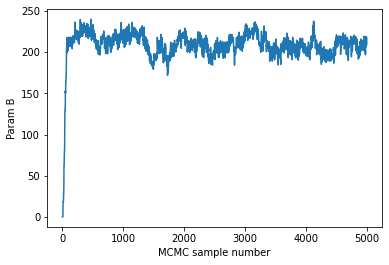

In [11]:
plt.plot(chain[:,0])
plt.xlabel('MCMC sample number')
plt.ylabel('Param B');

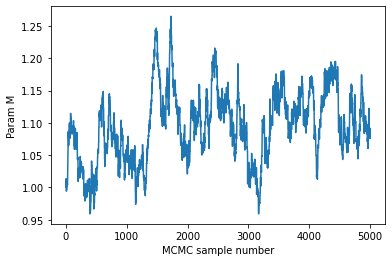

In [12]:
plt.plot(chain[:,1])
plt.xlabel('MCMC sample number')
plt.ylabel('Param M');

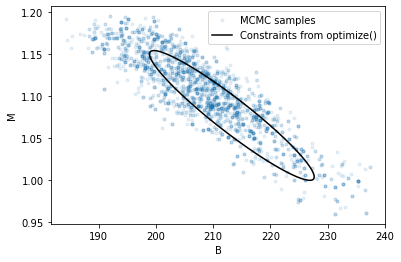

In [13]:
Nburn = steps//2
plt.plot(chain[Nburn:,0], chain[Nburn:,1], '.', alpha=0.1, label='MCMC samples')
plt.xlabel('B')
plt.ylabel('M');
plt.plot(R.x[0] + dbm[:,0], R.x[1] + dbm[:,1], 'k-', label='Constraints from optimize()');
#plt.plot(R.x[0] + 2.*dbm[:,0], R.x[1] + 2.*dbm[:,1], 'r-');
plt.legend();

The MCMC algorithm offers beautiful theoretical properties, but only in the limit of *infinite samples*.

*In the limit*, the distribution of the chain returned by MCMC matches the distribution of the *logprob* function
you gave it.

This is bitter sweet, and why using MCMC retains some mystique.

Some things that cause problems:

- multi-modal distributions -- mountains separated by prairies
- step sizes too big -- big jumps, often rejected
- step sizes too small -- timid jumps, too often accepted

And an over-arching question is "is my chain converged yet?"  That is, would my result change if I ran for twice as long?  There is "folk wisdom" but no objectively satisfying answer here.

Brief warnings ("here by dragons").  If you go here, you need to read about *Detailed Balance* to ensure your
algorithm still works:

- beware non-symmetric jumps (eg anything other than a Gaussian jump)
- don't try to adjust step sizes as the algorithm proceeds


## MCMC Step sizes

In our MCMC routine above, we jump in all parameters at once.  Instead, we can jump in just parameter per round,
and record the acceptance rates per parameter.

In [14]:
def mcmc_two(logprob, p0, stepsizes, steps, logprob_args):
    '''
    * logprob: a function that returns the log-probability at a given value of parameters.
        lnp = logprob(p, *logprob_args)
    * p0: initial position in parameter space (np array, size P)
    * stepsizes: (np array, size P): size of Gaussian jumps in parameter space
    * step: int: number of MCMC steps to take
    * logprob_args: extra arguments passed to the *logprob* function
    
    Returns  (chain, logprobs, naccept)
    * chain: size Nsteps x P, MCMC samples
    * logprobs: size Nsteps, logprobs at *chain* positions
    * njump: size P: number of MCMC proposed jumps for each parameter
    * naccept: size P: number of MCMC proposed jumps that were accepted for each parameter
    '''
    # Compute log-probability at initial parameters p0
    p = p0
    lnp = logprob(p, *logprob_args)

    # initialize output arrays
    chain = np.zeros((steps, len(p)), np.float32)
    logprobs = np.zeros(steps, np.float32)
    njump = np.zeros(len(p), int)
    naccept = np.zeros(len(p), int)

    # main MCMC loop
    for i in range(steps):
        # Propose to jump to a new spot in parameter space.
        # Depends only on p: hence Markov
        # 1. choose which parameter to jump in
        j = np.random.randint(len(p))
        p_new = p.copy()
        p_new[j] += np.random.normal(scale=stepsizes[j])
        njump[j] += 1
        # Compute logprob at new spot
        lnp_new = logprob(p_new, *logprob_args)
        # Our proposal distribution is symmetric (equal prob of proposing the reverse jump)
        # so we need only compare the ratio of lnp_new to current lnp.
        ratio = np.exp(lnp_new - lnp)
        # We draw a UNIFORM random number and *accept* if it is less than the ratio.
        # (Note that this means we *always* accept if ratio>1!)
        # Monte Carlo!
        urand = np.random.uniform()
        if urand < ratio:
            # Accept jump!
            p = p_new
            lnp = lnp_new
            naccept[j] += 1
        else:
            # Reject jump!
            pass
        # Crucial: we save the current *p* regardless of whether we accepted the jump or not --
        # so for rejected jumps, we have duplicate entries in the chain!
        chain[i,:] = p
        logprobs[i] = lnp
    return chain, logprobs, njump, naccept

In [15]:
# Initial position in parameter space
p0 = [0., 1.]
# "Jump" sizes
stepsizes = [20., 0.1]
# Number of MCMC steps
steps = 5000
chain, logprobs, njump, naccept = mcmc_two(log_likelihood_one, p0, stepsizes, steps, (x, y, yerr))
print(naccept / njump)

[0.27742194 0.30735412]


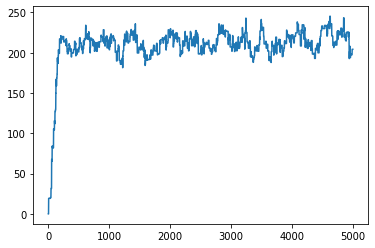

In [16]:
plt.plot(chain[:,0]);

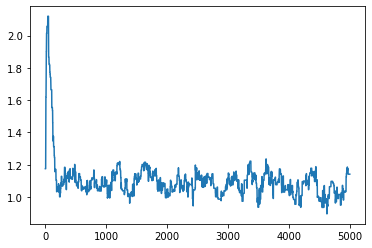

In [17]:
plt.plot(chain[:,1]);

# Modeling outliers

Now, let's see how we might handle our data set with outliers using a probabilistic modeling approach.

To do this, we're going to use a *mixture model*.  This is a kind of model where we say that each data point
can be drawn from one of several different distributions.  We don't know which distribution each data point was
drawn from, of course!

A mixture model is straightforward to write down.  Say we have two distributions (or "components"), $A$ and $B$,
with parameters $PA$ and $PB$, and a *mixing weight* $\alpha$.  Then we can write the likelihood as

$p(x | \alpha, PA, PB) = \alpha \, p_A(x | PA) + (1 - \alpha) p_B(x | PB)$

Note that the $p(...)$ syntax is really strongly overloaded -- I added the subscript $A$ on $p_A$ to remind us
that this is the probability distribution for mixture component $A$.  This could have a totally different functional form than $p_B$.

In this model, we *believe* the data are generated by *either* process $A$ or process $B$, but when we're *inferring* the parameters of $A$ and $B$, we don't know which process generated each data point, so we have to *sum* (marginalize) over the possibilities.

For an outlier model, our two distributions are going to be the "foreground" or "good" process -- the straight line model with errors $yerr$ -- and the "background" or "bad" process, which generates outliers.  What distribution should we write down for this?

One simple approach is to take the range of your data and say that the "outlier" distribution has equal likelihood over that whole range.  So, we might give it a Uniform distribution over the range `0` to `800` (being a bit generous).

Below, I'm going to rename $\alpha$ to `p_good` -- the probability that a data point is good.  And we're going to infer that `p_good`.  If we had a more complicated background model, we could infer its parameters too.

In [18]:
def log_likelihood_two(params, x, y, yerr, ylo, yhi):
    p_good, b, m = params
    if p_good < 0 or p_good > 1:
        return -np.inf
    ypred = b + m * x
    chi = (y - ypred) / yerr
    loglike_fg = -0.5 * chi**2 - (np.log(yerr) + 0.5*np.log(2.*np.pi))
    loglike_bg = np.log(1. / (yhi - ylo))
    loglike = np.logaddexp(np.log(p_good) + loglike_fg, np.log(1.-p_good) + loglike_bg)
    return np.sum(loglike)

Let's look at what the *likelihood* for $y$ looks like for a single $x$ value.

<ipython-input-18-5a03bab5edd5>:9: RuntimeWarning: divide by zero encountered in log
  loglike = np.logaddexp(np.log(p_good) + loglike_fg, np.log(1.-p_good) + loglike_bg)


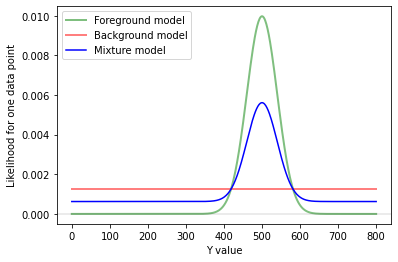

In [19]:
xi = 300
yei = 40
yy = np.linspace(0, 800, 500)
llAi = [log_likelihood_two((1.0, 200., 1.), xi, yi, yei, 0., 800.) for yi in yy]
llBi = [log_likelihood_two((0.0, 200., 1.), xi, yi, yei, 0., 800.) for yi in yy]
plt.plot(yy, np.exp(llAi), 'g-', alpha=0.5, lw=2, label='Foreground model')
plt.plot(yy, np.exp(llBi), 'r-', alpha=0.5, lw=2, label='Background model')
lli = [log_likelihood_two((0.5, 200., 1.), xi, yi, yei, 0., 800.) for yi in yy]
plt.plot(yy, np.exp(lli), 'b-', label='Mixture model')
plt.xlabel('Y value')
plt.ylabel('Likelihood for one data point')
plt.legend()
plt.axhline(0., color='k', alpha=0.1);

Let's pin `p_good` at a constant and see what the whole `B,M` parameter space looks like.

In [20]:
BB,MM = np.meshgrid(np.linspace(100., 300., 100), np.linspace(0.5, 2.5, 100))
LL = np.zeros_like(BB)
for i,(bb,mm) in enumerate(zip(BB.ravel(), MM.ravel())):
    LL.flat[i] = log_likelihood_two((0.8, bb, mm), x, y, yerr, 0., 800.)

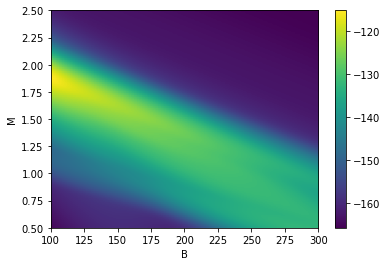

In [21]:
plt.imshow(LL, origin='lower', extent=[BB.min(), BB.max(), MM.min(), MM.max()], aspect='auto')
plt.xlabel('B')
plt.ylabel('M')
plt.colorbar();

In [22]:
p0 = [0.8, 100., 2.]
stepsizes = [0.01, 10., 0.01]
steps = 10000
chain, logprobs, naccept = mcmc_one(log_likelihood_two, p0, stepsizes, steps, (x, y, yerr, 0., 800.))
naccept / steps

0.5203

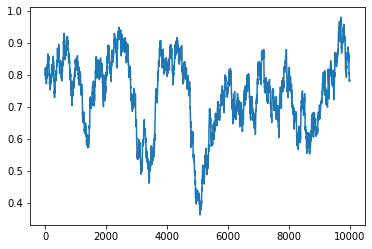

In [23]:
plt.plot(chain[:,0]);

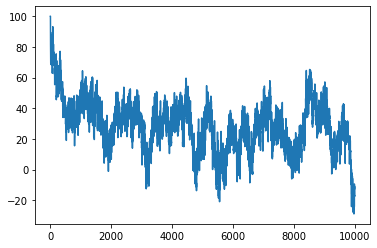

In [24]:
plt.plot(chain[:,1]);

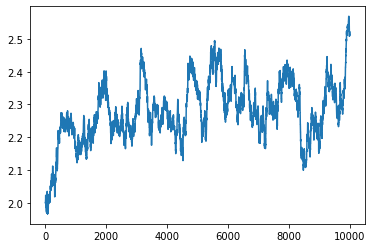

In [25]:
plt.plot(chain[:,2]);

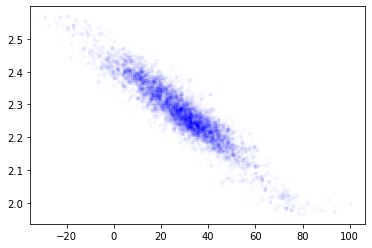

In [26]:
plt.plot(chain[:,1], chain[:,2], 'b.', alpha=0.01);

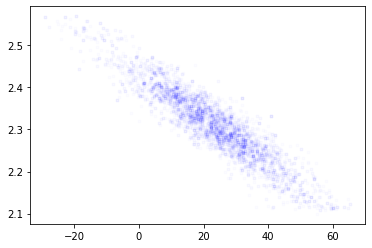

In [27]:
burn = slice(steps//2,None)
plt.plot(chain[burn,1], chain[burn,2], 'b.', alpha=0.01);

In [28]:
import corner

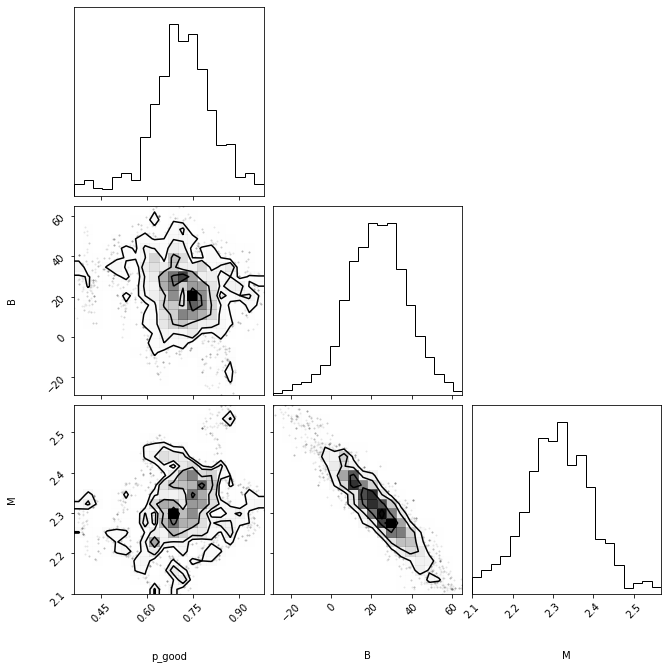

In [29]:
fig = plt.figure(figsize=(10,10))
corner.corner(chain[burn,:], labels=['p_good', 'B', 'M'], fig=fig);

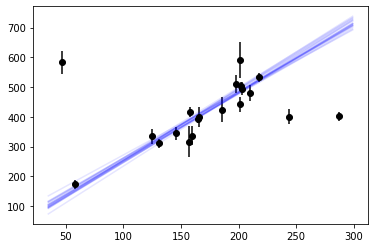

In [32]:
plt.errorbar(x, y, yerr=yerr, fmt='o', color='k');
ax = plt.axis()
xx = np.array(ax[:2])
for i in range(20):
    ii = np.random.randint(low=steps//2, high=steps)
    pg,b,m = chain[ii,:]
    plt.plot(xx, b + xx*m, 'b-', alpha=0.1);